# Прогнозирование успешного завершения онлайн-курса "Анализ данных в R"
## По данным о первых двух днях активности студентов предсказывается, наберут ли они более 40 правильных решений за весь курс.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [3]:
def load_data():
    """Загрузка тренировочных и тестовых данных"""
    events_data_train = pd.read_csv('data/event_data_train.csv')
    submissions_data_train = pd.read_csv('data/submissions_data_train.csv')
    events_data_test = pd.read_csv('data/events_data_test.csv')
    submissions_data_test = pd.read_csv('data/submission_data_test.csv')
    return events_data_train, submissions_data_train, events_data_test, submissions_data_test

In [4]:
print("Загрузка данных...")
events_train, submissions_train, events_test, submissions_test = load_data()

Загрузка данных...


In [5]:
events_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [6]:
submissions_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
print(f"\nРазмеры данных:")
print(f"events_train: {events_train.shape}")
print(f"submissions_train: {submissions_train.shape}")
print(f"events_test: {events_test.shape}")
print(f"submissions_test: {submissions_test.shape}")


Размеры данных:
events_train: (3480703, 4)
submissions_train: (509104, 4)
events_test: (274768, 4)
submissions_test: (42261, 4)


In [8]:
def data_preparation(events_data, submissions_data):
    """
    Создание базового датасета с действиями пользователей
    """
    # Создаем базовый датасет со всеми действиями юзеров
    users_events_data = events_data.pivot_table(
        index='user_id',
        columns='action',
        values='step_id',
        aggfunc='count',
        fill_value=0
    ).reset_index()

    # Датасет с количеством правильных и неправильных попыток
    users_scores = submissions_data.pivot_table(
        index='user_id',
        columns='submission_status',
        values='step_id',
        aggfunc='count',
        fill_value=0
    ).reset_index()

    # Соединяем в один датасет
    users_data = users_scores.merge(users_events_data, on='user_id', how='outer')
    users_data = users_data.fillna(0)

    return users_data

In [9]:
def create_time_features(events_data):
    """
    Создание временных фич
    """
    events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
    events_data['day'] = events_data.date.dt.date

    # Таблица с первым и последним действием юзера и количеством уникальных дней
    users_time_feature = events_data.groupby('user_id').agg({
        'timestamp': ['min', 'max'],
        'day': 'nunique'
    }).droplevel(level=0, axis=1).rename(columns={
        'nunique': 'days'
    }).reset_index()

    return users_time_feature

def time_filter(data, days=2):
    """
    Фильтрация данных по временному окну (первые N дней)
    """
    user_min_time = data.groupby('user_id').agg({
        'timestamp': 'min'
    }).rename({'timestamp': 'min_timestamp'}, axis=1).reset_index()

    data_with_time_filter = data.merge(user_min_time, on='user_id', how='outer')

    # Отбираем записи не позднее N дней с начала учебы
    time_threshold = days * 24 * 60 * 60  # перевели в секунды
    data_with_time_filter = data_with_time_filter.query(
        "timestamp <= min_timestamp + @time_threshold"
    )
    data_with_time_filter = data_with_time_filter.drop('min_timestamp', axis=1)

    return data_with_time_filter

In [10]:
def passed_course_feature(submission_data, threshold=40):
    """
    Создание целевой переменной - прохождение курса
    """
    users_count_correct = submission_data[submission_data.submission_status == 'correct'] \
        .groupby('user_id') \
        .agg({'step_id': 'count'}) \
        .reset_index() \
        .rename(columns={'step_id': 'corrects'})

    users_count_correct['passed_course'] = (users_count_correct.corrects >= threshold).astype('int')
    users_count_correct = users_count_correct.drop('corrects', axis=1)

    return users_count_correct

In [12]:
def steps_tried_feature(submissions_data):
    """
    Количество уникальных шагов, которые попробовал пользователь
    """
    steps_tried = submissions_data.groupby('user_id').step_id.nunique() \
        .to_frame().reset_index().rename(columns={'step_id': 'steps_tried'})

    return steps_tried

def correct_ratio_feature(data):
    """
    Расчет доли правильных ответов
    """
    data['correct_ratio'] = (data.correct / (data.correct + data.wrong)).fillna(0)
    return data

In [14]:
def create_train_dataframe(events_data, submission_data):
    """
    Формирование финального датасета для обучения
    """
    # Фильтрация данных за два дня
    events_time_filter = time_filter(events_data)
    submissions_time_filter = time_filter(submission_data)

    # Создание таблиц с фичами
    users_data = data_preparation(events_time_filter, submissions_time_filter)
    users_passed_course = passed_course_feature(submission_data)
    users_time_feature = create_time_features(events_time_filter)
    users_steps_tried = steps_tried_feature(submissions_time_filter)
    users_data = correct_ratio_feature(users_data)

    # Объединение всех фич
    first_merge = users_data.merge(users_steps_tried, how='outer').fillna(0)
    second_merge = first_merge.merge(users_time_feature, how='outer')
    third_merge = second_merge.merge(users_passed_course, how='outer').fillna(0)

    # Разделение на признаки и целевую переменную
    y = third_merge.passed_course.map(int)
    X = third_merge.drop('passed_course', axis=1)

    return X, y

In [15]:
def create_test_dataframe(events_data, submission_data):
    """
    Формирование тестового датасета
    """
    # Фильтрация данных за два дня
    events_time_filter = time_filter(events_data)
    submissions_time_filter = time_filter(submission_data)

    # Создание таблиц с фичами
    users_data = data_preparation(events_time_filter, submissions_time_filter)
    users_time_feature = create_time_features(events_time_filter)
    users_steps_tried = steps_tried_feature(submissions_time_filter)
    users_data = correct_ratio_feature(users_data)

    # Объединение фич
    first_merge = users_data.merge(users_steps_tried, how='outer').fillna(0)
    X = first_merge.merge(users_time_feature, how='outer')

    return X

In [16]:
X_train, y_train = create_train_dataframe(events_train, submissions_train)

In [17]:
X_test = create_test_dataframe(events_test, submissions_test)

In [18]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (19234, 12), y_train: (19234,)
X_test: (6184, 12)


In [19]:
X_train.head()

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,correct_ratio,steps_tried,min,max,days
0,1,0.0,0.0,1,0,0,1,0.0,0.0,1472827464,1472827464,1
1,2,2.0,0.0,9,9,2,9,1.0,2.0,1514383364,1514383555,1
2,3,4.0,4.0,15,15,4,20,0.5,4.0,1434358476,1434359582,1
3,5,2.0,2.0,1,1,0,1,0.5,2.0,1466156809,1466156809,1
4,7,0.0,0.0,1,1,0,1,0.0,0.0,1521634660,1521634660,1


In [22]:
y_train.head(15)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    1
14    0
Name: passed_course, dtype: int64

### Обучение модели

In [23]:
def train_random_forest(X, y, test_size=0.2):
    """
    Обучение модели Random Forest с подбором параметров
    """
    # Разделение на тренировочную и валидационную выборки
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Размеры выборок:")
    print(f"X_train_split: {X_train_split.shape}, y_train_split: {y_train_split.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    # Параметры для GridSearch
    parameters = {
        'n_estimators': range(20, 51, 3),
        'max_depth': range(5, 14)
    }
    
    # Создание и обучение модели с кросс-валидацией
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(rf, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
    
    print("\nОбучение модели...")
    grid_search.fit(X_train_split, y_train_split)
    
    print(f"\nЛучшие параметры: {grid_search.best_params_}")
    
    # Предсказания на валидационной выборке
    y_pred = grid_search.predict(X_val)
    y_pred_prob = grid_search.predict_proba(X_val)
    
    # Оценка модели
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_prob[:, 1])
    
    print(f"Accuracy на валидационной выборке: {accuracy:.3f}")
    print(f"ROC AUC score: {roc_auc:.5f}")
    
    return grid_search.best_estimator_, grid_search.best_params_

In [24]:
best_model, best_params = train_random_forest(X_train, y_train)

Размеры выборок:
X_train_split: (15387, 12), y_train_split: (15387,)
X_val: (3847, 12), y_val: (3847,)

Обучение модели...

Лучшие параметры: {'max_depth': 6, 'n_estimators': 44}
Accuracy на валидационной выборке: 0.914
ROC AUC score: 0.91118


### Предсказания

In [25]:
def make_predictions(model, X_test, X_train_full, y_train_full):
    """
    Предсказание на тестовых данных
    """
    # Переобучение модели на всех тренировочных данных с лучшими параметрами
    print("Переобучение модели на всех тренировочных данных...")
    final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    final_model.fit(X_train_full, y_train_full)
    
    # Предсказание вероятностей для тестовых данных
    print("Предсказание для тестовых данных...")
    y_test_pred_prob = final_model.predict_proba(X_test)
    
    # Создание датафрейма с результатами
    result = X_test['user_id'].to_frame()
    result['is_gone'] = y_test_pred_prob[:, 1]
    
    return result, final_model

In [27]:
results, final_model = make_predictions(best_model, X_test, X_train, y_train)
results.head(15)

Переобучение модели на всех тренировочных данных...
Предсказание для тестовых данных...


,user_id,is_gone
0,4,0.000048
1,6,0.000048
2,10,0.000045
3,12,0.079339
4,13,0.399679
5,15,0.203503
6,19,0.000048
7,21,0.417061
8,23,0.000048
9,35,0.146421


In [28]:
print(f"\nСтатистика предсказаний:")
print(f"Мин. вероятность: {results['is_gone'].min():.3f}")
print(f"Макс. вероятность: {results['is_gone'].max():.3f}")
print(f"Средняя вероятность: {results['is_gone'].mean():.3f}")


Статистика предсказаний:
Мин. вероятность: 0.000
Макс. вероятность: 0.930
Средняя вероятность: 0.069


In [29]:
output_file = 'submission.csv'
results[['user_id', 'is_gone']].to_csv(output_file, index=False)
print(f"Результаты сохранены в файл: {output_file}")

Результаты сохранены в файл: submission.csv


In [31]:
# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Топ-10 важных признаков:")
display(feature_importance.head(10))

Топ-10 важных признаков:


,feature,importance
1,correct,0.353597
8,steps_tried,0.185304
4,passed,0.143028
10,max,0.056585
3,discovered,0.056088
9,min,0.050240
2,wrong,0.045897
5,started_attempt,0.041182
7,correct_ratio,0.034001
0,user_id,0.015294


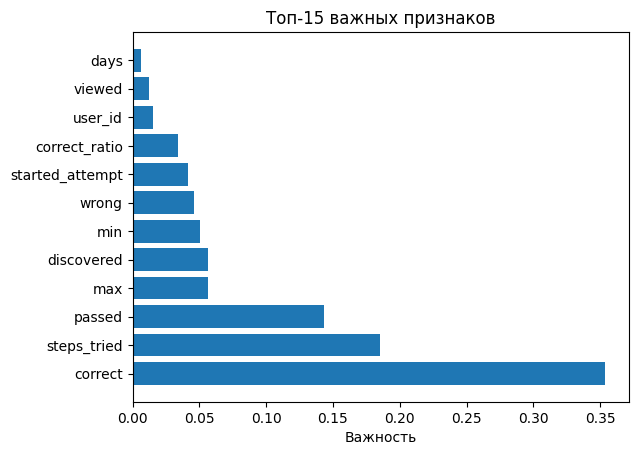

In [35]:
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Важность')
plt.title('Топ-10 важных признаков')
plt.show()

In [36]:
print("Распределение целевой переменной в тренировочных данных:")
target_distribution = pd.DataFrame({
    'Класс': ['Не прошел (0)', 'Прошел (1)'],
    'Количество': [sum(y_train == 0), sum(y_train == 1)],
    'Доля': [sum(y_train == 0)/len(y_train), sum(y_train == 1)/len(y_train)]
})
display(target_distribution)

Распределение целевой переменной в тренировочных данных:


,Класс,Количество,Доля
0,Не прошел (0),17221,0.895342
1,Прошел (1),2013,0.104658


# Итог
Модель обучена и предсказания сохранены в файл `submission.csv`. Результаты содержат:
- `user_id` - идентификатор пользователя
- `is_gone` - вероятность того, что пользователь наберет более 40 правильных решений за курс